In [1]:
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from f1tenth_benchmarks.utils.MapData import MapData
# from f1tenth_benchmarks.data_tools.plotting_utils import *
# from f1tenth_benchmarks.data_tools.process_data import process_data

# if os.getcwd().split('/')[-1] == 'benchmark_results':
#     os.chdir('..')
#     os.chdir('..')
#     print(f'Changed directory to root of repo: {os.getcwd()}')

# save_path = 'Data/BenchmarkArticle/'
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# process_data()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
# Ensure these modules can be imported from the new location
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.data_tools.process_data import process_data

import matplotlib as mpl

# Set Matplotlib to use Type 1 fonts
mpl.rcParams['pdf.fonttype'] = 42  # Use Type 1 or TrueType fonts, not Type 3
mpl.rcParams['ps.fonttype'] = 42


# Explicitly define the root of the repo based on the known structure of your working directory
repo_root = '/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks'
print(f'Working from the repo root: {repo_root}')

# Now we use the repo_root for defining other paths
save_path = os.path.join(repo_root, 'Data', 'BenchmarkArticle')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Assuming process_data() works with paths relative to the repo root, adjust if necessary
os.chdir(repo_root)  # Change the working directory to repo_root if required by process_data()
process_data()

Working from the repo root: /home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks
Complied Full.csv and Summary.csv.


# Load Data

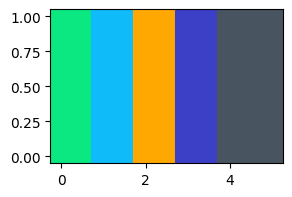

In [2]:
planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd",  "EndToEnd",  "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]
#planners = ['GlobalPlanPP', "GlobalPlanMPCC", "EndToEnd", "TinyLidarNet"]
planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd",  "EndToEnd",  "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]
planners = ["EndToEnd",  "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]
planners = ["EndToEnd",  "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]#, "TinyLidarNet"]
planners = ["EndToEnd",  "EndToEnd", "EndToEnd", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]
# planners = ['GlobalPlanPP',"EndToEnd",  "EndToEnd", "EndToEnd", "TinyLidarNet", "TinyLidarNet", "TinyLidarNet"]
# test_ids = ["benchmark"] * 4
test_ids = ["benchmark_pp", "benchmark_ftg", "benchmark_e2e_il", "benchmark_e2e_drl", "benchmark_tiny_il", "benchmark_tiny_il_m", "benchmark_tiny_il_l", "benchmark_tiny_il_mean", "benchmark_tiny_il_min", "benchmark_tiny_il_max"]
test_ids = ["benchmark_e2e_il_l", "benchmark_tiny_il", "benchmark_tiny_il_m", "benchmark_tiny_il_l"]#, "benchmark_tiny_il_temporal", "benchmark_tiny_il_birdeye"]#, "benchmark_tiny_il_mean", "benchmark_tiny_il_min", "benchmark_tiny_il_max"]
# test_ids = ["benchmark_e2e_il`_l", "benchmark_tiny_il_m", "benchmark_tiny_il_mean", "benchmark_tiny_il_min", "benchmark_tiny_il_max"]
test_ids = ["benchmark_e2e_il", "benchmark_e2e_il_m", "benchmark_e2e_il_l", "benchmark_tiny_il", "benchmark_tiny_il_m", "benchmark_tiny_il_l"]


neat_planner_names = [
    # "Opti. & tracking",
    # "Follow-the-Gap",
    r"MLP256$^s$",
    r"MLP256$^m$",
    r"MLP256$^l$",
    # "MLP128",
    #"MLP256(DRL)",
    r"TinyLidarNet$^s$",
    r"TinyLidarNet$^m$",
    r"TinyLidarNet$^l$",
    # r"TinyLidarNet$^temporal$",
    # r"TinyLidarNet$^birdeye$",
    #r"TinyLidarNet$^s$$_{mean}$",
    #r"TinyLidarNet$^s$$_{min}$",
    #r"TinyLidarNet$^s$$_{max}$",
    #'TinyLidarNet(DRL)'
]



n_planners = len(planners)
map_list = ["example","MoscowRaceway", "Austin", "Spielberg"]

#planner_colors = [chrome_yellow, lighter_purple]
planner_colors = [red_orange,   minty_green, disco_ball, chrome_yellow,   free_speech, good_grey,  vibe_yellow, periwinkle, sweedish_green, high_pink,]
#planner_colors = [red_orange,   minty_green, chrome_yellow, disco_ball, good_grey, free_speech,   vibe_yellow]

plt.figure(figsize=(3, 2))
for i in range(n_planners):
    plt.plot([i, i], [0, 1], color=planner_colors[i], linewidth=80)
    

lap_n = 0
test_id_display = ["benchmark_e2e_il_m", "benchmark_tiny_il_m"]
#moscow : 3
#example : 0

In [3]:
process_data()

summary_df = pd.read_csv("/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/Summary.csv")
results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

# print(results_df)

times_df = results_df[['TestID', 'MapName', 'AvgTime']]
times_df = times_df.pivot(index="TestID", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
times_df.sort_values(by="TestID", inplace=True, ascending=False)
times_df = times_df[['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE']]
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")


Complied Full.csv and Summary.csv.
MapName               AUSTIN  MOSCOWRACEWAY  SPIELBERG  EXAMPLE
TestID                                                         
benchmark_tiny_il_m  86.8875        64.9325    68.2800  30.1875
benchmark_tiny_il_l  85.6750        63.2775    65.3750  26.7375
benchmark_tiny_il    83.3950        61.8350    64.1375  26.9075
benchmark_e2e_il_m       NaN        64.2850    65.7188  28.3917
benchmark_e2e_il_l       NaN        58.8000    58.3417      NaN
benchmark_e2e_il         NaN            NaN    62.1750  27.5708


In [4]:
process_data()

summary_df = pd.read_csv("/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/Full.csv")
results_df = summary_df.loc[summary_df.TestID.isin(test_ids)]

#print(results_df)
times_df = results_df[['TestID', 'TestMap', 'LapComplete']]
complete_df = results_df[results_df['LapComplete'] == True]

# Group by TestID and TestMap, count crashes and total laps
complete_counts = complete_df.groupby(['TestID', 'TestMap']).count()['LapComplete']
total_laps = results_df.groupby(['TestID', 'TestMap']).count()['LapComplete']

# Calculate crash percentage
complete_percentage = (complete_counts / total_laps) * 100

# Reset index to get TestID and TestMap back as columns
complete_percentage = complete_percentage.reset_index()

# Rename the column for clarity
complete_percentage.rename(columns={'LapComplete': 'CompletionRate'}, inplace=True)


# Pivot the DataFrame
complete_percentage = complete_percentage.pivot(index='TestID', columns='TestMap', values='CompletionRate')
complete_percentage.columns = complete_percentage.columns.str.upper()
complete_percentage = complete_percentage[['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE']]
# Display the pivoted DataFrame
print(complete_percentage)


Complied Full.csv and Summary.csv.
TestMap              AUSTIN  MOSCOWRACEWAY  SPIELBERG  EXAMPLE
TestID                                                        
benchmark_e2e_il        NaN            NaN       10.0     60.0
benchmark_e2e_il_l      NaN           10.0       30.0      NaN
benchmark_e2e_il_m      NaN           50.0       40.0     90.0
benchmark_tiny_il     100.0          100.0      100.0    100.0
benchmark_tiny_il_l   100.0          100.0      100.0    100.0
benchmark_tiny_il_m   100.0          100.0      100.0    100.0


In [5]:
# Extract relevant columns
progress_df = results_df[['TestID', 'TestMap', 'Progress']]

# Filter progress for values greater than 0.995
progress_df['Progress'] = progress_df['Progress'].apply(lambda x: 1 if x >= 0.995 else x)

# Group by TestID and TestMap, calculate average progress
average_progress = progress_df.groupby(['TestID', 'TestMap']).mean()['Progress']

# Reset index to get TestID and TestMap back as columns
average_progress = average_progress.reset_index()

average_progress['Progress'] = average_progress['Progress'] * 100

# Pivot the DataFrame
average_progress = average_progress.pivot(index='TestID', columns='TestMap', values='Progress')
average_progress.columns = average_progress.columns.str.upper()
average_progress = average_progress[['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE']]

# Display the pivoted DataFrame
average_progress.to_csv('Progress.csv')

print(average_progress)


TestMap               AUSTIN  MOSCOWRACEWAY  SPIELBERG  EXAMPLE
TestID                                                         
benchmark_e2e_il      48.249         28.553     37.085   77.002
benchmark_e2e_il_l    16.189         42.397     61.113   30.888
benchmark_e2e_il_m    16.580         58.055     78.079   99.640
benchmark_tiny_il    100.000        100.000    100.000  100.000
benchmark_tiny_il_l  100.000        100.000    100.000  100.000
benchmark_tiny_il_m  100.000        100.000    100.000  100.000


/tmp/ipykernel_196549/3978232171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progress_df['Progress'] = progress_df['Progress'].apply(lambda x: 1 if x >= 0.995 else x)


In [6]:
summary_df = pd.read_csv("/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/Summary.csv")
results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

# print(results_df)

times_df = results_df[['TestID', 'MapName', 'AvgTime']]
times_df = times_df.pivot(index="TestID", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df = times_df[['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE']]
print(times_df.columns)
print(complete_percentage.columns)
combined_df = pd.merge(times_df, complete_percentage, left_index=True, right_index=True, suffixes=('_AvgTime', '_CompletionRate'))

# Sort columns for consistency
combined_df = combined_df.sort_index(axis=1, level=0)

# Display the combined DataFrame
print(combined_df)


Index(['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE'], dtype='object', name='MapName')
Index(['AUSTIN', 'MOSCOWRACEWAY', 'SPIELBERG', 'EXAMPLE'], dtype='object', name='TestMap')
                     AUSTIN_AvgTime  AUSTIN_CompletionRate  EXAMPLE_AvgTime  \
TestID                                                                        
benchmark_e2e_il                NaN                    NaN          27.5708   
benchmark_e2e_il_l              NaN                    NaN              NaN   
benchmark_e2e_il_m              NaN                    NaN          28.3917   
benchmark_tiny_il           83.3950                  100.0          26.9075   
benchmark_tiny_il_l         85.6750                  100.0          26.7375   
benchmark_tiny_il_m         86.8875                  100.0          30.1875   

                     EXAMPLE_CompletionRate  MOSCOWRACEWAY_AvgTime  \
TestID                                                               
benchmark_e2e_il                       60.0  

/tmp/ipykernel_196549/206368480.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


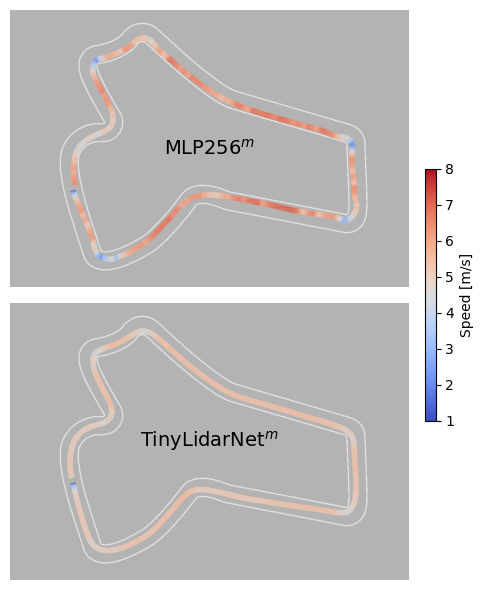

In [7]:
for plot_map in [
    "example",
    # "MoscowRaceway"
    ]:
    map_data = MapData(plot_map)
    lap_dfs = []
    # print(os.getcwd())

    for i, planner_name in enumerate(planners):
        data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        # df["planner"] = planner_name
        df["planner"] = test_ids[i]

        lap_dfs.append(df)
    lap_df = pd.concat(lap_dfs)

    fig, axs = plt.subplots(2, 1, figsize=(7., 6), sharex=True, sharey=True)
    axs_list = axs.flatten()
    test_id_itr = 0
    # print(test_id_display)
    # print(test_ids)
    # line = None

    for i in range(n_planners):
        
        if(test_id_itr >= len(test_id_display)):
            break
        plt.sca(axs_list[test_id_itr])
        map_data.plot_map_img()
        if(test_id_display[test_id_itr] == test_ids[i]):
            # print(test_id_display[test_id_itr])
            # print('True')
            # print(f'i: {i}')
            # print(f'test_id_itr: {test_id_itr}')
            # print(f'test_ids[{i}]: {test_ids[i]}')
            # print(f'test_id_display[{test_id_itr}] : {test_id_display[test_id_itr] }')
            # print(f'neat_planner_names[{i}]: {neat_planner_names[i]}')

            df = lap_df[lap_df["planner"] == test_ids[i]]
            #df = lap_df[lap_df["planner"] == test_ids[i]]
            xs, ys = map_data.xy2rc(df.x, df.y)
            pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
            segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
            norm = plt.Normalize(1, 8)
            lc = LineCollection(segments, cmap='coolwarm', norm=norm)
            lc.set_array(df.speed.values)
            lc.set_linewidth(4)
            line = plt.gca().add_collection(lc)
                
            plt.axis('off')
            axs_list[test_id_itr].set_aspect('equal')
            plt.xlim(250, 1400)
            plt.ylim(400, 1200)
            plt.text(0.5, 0.5, neat_planner_names[i], horizontalalignment='center', verticalalignment='center', transform=axs_list[test_id_itr].transAxes, size=14)
            test_id_itr+=1

    # Remove the last subplot
    # fig.delaxes(axs_list[-1])

    # Add colorbar
    cax = fig.add_axes([axs_list[-1].get_position().x1+0.08, axs_list[-1].get_position().y0+0.18, 0.015, axs_list[-1].get_position().height*1.2])
    plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[1, 2, 3, 4, 5, 6, 7,8])

    plt.tight_layout()
    plt.savefig(f"{save_path}speed_trajectories_{plot_map}.pdf", bbox_inches='tight', dpi=300)


/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/Data/BenchmarkArticle


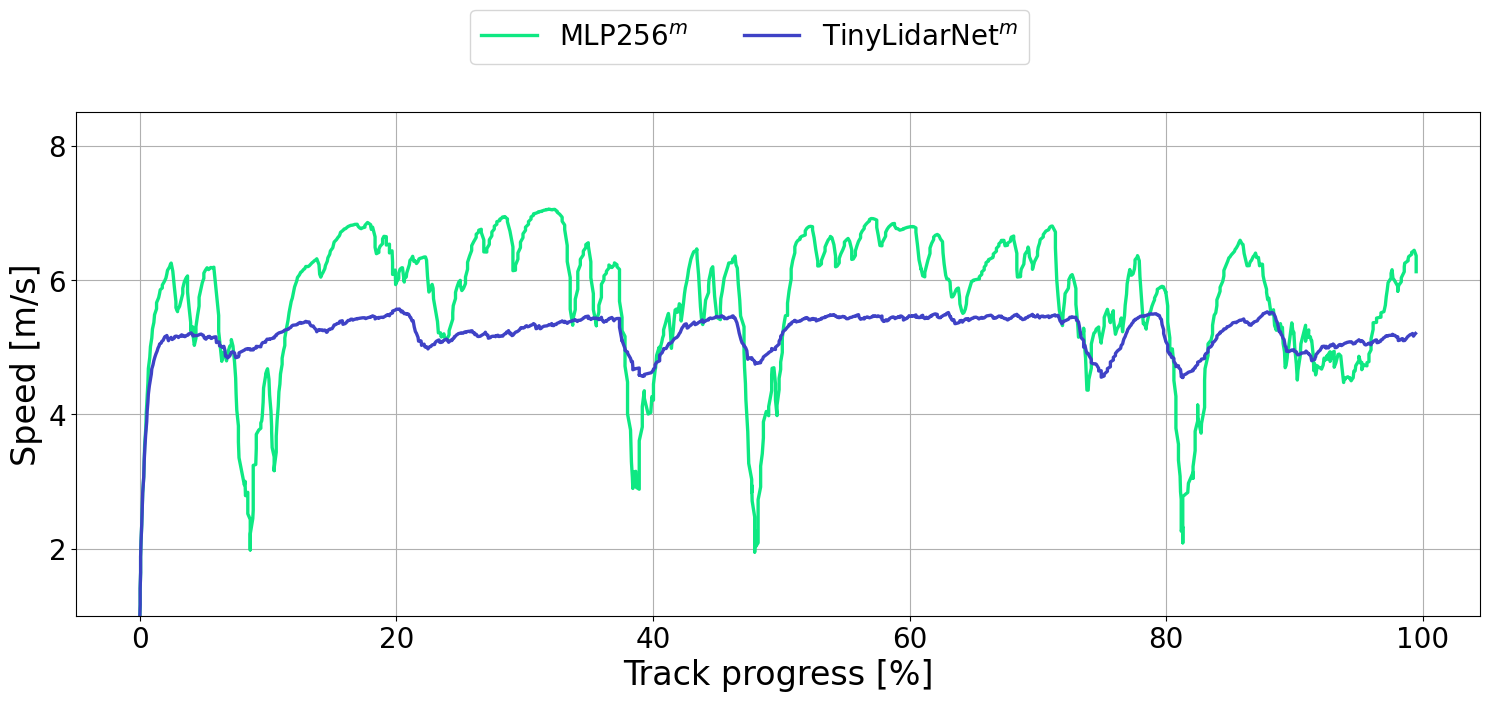

In [8]:
for map_name in [
    "example", 
    # "MoscowRaceway"
    ]:

    lap_dfs = []
    for i, planner_name in enumerate(planners):
        data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        #df["planner"] = planner_name
        df["planner"] = test_ids[i]

        lap_dfs.append(df)


    lap_df = pd.concat(lap_dfs)
    fig, ax1 = plt.subplots(1, 1, figsize=(15., 7.2), sharex=True)
    map_data = MapData(map_name)

    test_id_itr = 0
    for test_id_itr in range(len(test_id_display)):
        for i in range(n_planners):
            if test_id_display[test_id_itr] in test_ids[i]:
                df = lap_df[lap_df["planner"] == test_ids[i]]
                ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)


    # for i in range(n_planners):
    #     #df = lap_df[lap_df["planner"] == planners[i]]
    #     # df = lap_df[lap_df["planner"] == test_ids[i]]

    #     ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

    ax1.grid(True)
    ax1.set_ylim(1., 8.5)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

    plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=20)
    plt.xlabel("Track progress [%]", fontsize=24)
    plt.ylabel("Speed [m/s]", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}speed_comparison_{map_name}.pdf", bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.savefig(f"{save_path}speed_comparison_{map_name}.svg", bbox_inches='tight', pad_inches=0.0)
    print(save_path)

In [9]:
# plot_map = "example"
# lap_n = 7
# lap_dfs = []
# for i, planner_name in enumera99.6te(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]

#     lap_dfs.append(df)
# lap_df = pd.concat(lap_dfs)

# map_data = MapData(plot_map)
# map_data.plot_map_img()
# for i in range(n_planners-3):
#     #df = lap_df[lap_df["planner"] == planners[i]]
#     if test_ids[i] not in ["benchmark_e2e_drl",]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]

#         xs, ys = map_data.xy2rc(df.x, df.y)
#         plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
# plt.axis('off')
# plt.legend()
# # plt.xlim(200, 1400)
# # plt.ylim(400, 1300)
# plt.xlim(800, 1800)
# plt.ylim(500, 1500)

# plt.tight_layout()

In [10]:
# plot_map = "example"
# lap_n = 5
# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]

#     lap_dfs.append(df)
# lap_df = pd.concat(lap_dfs)

# map_data = MapData(plot_map)
# map_data.plot_map_img()
# for i in range(n_planners-3):
#     #df = lap_df[lap_df["planner"] == planners[i]]
#     if test_ids[i] not in ["benchmark_tiny_il_l","benchmark_tiny_il"]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]

#         xs, ys = map_data.xy2rc(df.x, df.y)
#         plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
# plt.axis('off')
# plt.legend()
# # plt.xlim(200, 1400)
# # plt.ylim(400, 1300)
# plt.xlim(800, 1800)
# plt.ylim(500, 1500)

# plt.tight_layout()

In [11]:
# plot_map = "example"
# lap_n = 5
# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]

#     lap_dfs.append(df)
# lap_df = pd.concat(lap_dfs)

# map_data = MapData(plot_map)
# map_data.plot_map_img()
# for i in range(n_planners-3):
#     #df = lap_df[lap_df["planner"] == planners[i]]
#     if test_ids[i] not in ["benchmark_e2e_drl", "benchmark_pp","benchmark_ftg"]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]

#         xs, ys = map_data.xy2rc(df.x, df.y)
#         plt.plot(xs, ys, linewidth=2.8, color=planner_colors[i], label=neat_planner_names[i])
    
# plt.axis('off')
# plt.legend()
# # plt.xlim(200, 1400)
# # plt.ylim(400, 1300)
# plt.xlim(800, 1800)
# plt.ylim(500, 1500)

# plt.tight_layout()


In [12]:
# map_name = "MoscowRaceway"
# lap_n = 3

# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]
    
    
#     lap_dfs.append(df)


# lap_df = pd.concat(lap_dfs)

# fig, ax1 = plt.subplots(1, 1, figsize=(10., 5.2), sharex=True)
# map_data = MapData(map_name)

# for i in range(n_planners-3):
#     if test_ids[i] not in ["benchmark_e2e_drl", "benchmark_tiny_il_m","benchmark_tiny_il"]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]
#         ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

# ax1.grid(True)
# ax1.set_ylim(1., 8.5)
# ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=10)
# plt.xlabel("Track progress [%]")
# plt.ylabel("Speed [m/s]")


In [13]:
# map_name = "MoscowRaceway"
# lap_n = 5

# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]
    
    
#     lap_dfs.append(df)


# lap_df = pd.concat(lap_dfs)

# fig, ax1 = plt.subplots(1, 1, figsize=(10., 5.2), sharex=True)
# map_data = MapData(map_name)

# for i in range(n_planners-3):
#     if test_ids[i] not in ["benchmark_e2e_drl", "benchmark_pp","benchmark_ftg"]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]
#         ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

# ax1.grid(True)
# ax1.set_ylim(1., 8.5)
# ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=10)
# plt.xlabel("Track progress [%]")
# plt.ylabel("Speed [m/s]")

# plt.tight_layout()

In [14]:
# map_name = "MoscowRaceway"
# lap_n = 5

# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]
    
    
#     lap_dfs.append(df)


# lap_df = pd.concat(lap_dfs)

# fig, ax1 = plt.subplots(1, 1, figsize=(10., 5.2), sharex=True)
# map_data = MapData(map_name)

# for i in range(n_planners):
#     if test_ids[i] not in ["benchmark_e2e_drl", "benchmark_pp", "benchmark_ftg", "benchmark_e2e_il", "benchmark_tiny_il_m", "benchmark_tiny_il_l",]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]
#         ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

# ax1.grid(True)
# ax1.set_ylim(1., 8.5)
# ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=10)
# plt.xlabel("Track progress [%]")
# plt.ylabel("Speed [m/s]")

# plt.tight_layout()

In [15]:
# map_name = "MoscowRaceway"
# lap_n = 5

# lap_dfs = []
# for i, planner_name in enumerate(planners):
#     data = np.load(f"/home/m810z573/Downloads/f1tenth_benchmarks/f1tenth_benchmarks/benchmark_results/Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
#     df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
#     #df["planner"] = planner_name
#     df["planner"] = test_ids[i]
    
    
#     lap_dfs.append(df)


# lap_df = pd.concat(lap_dfs)

# fig, ax1 = plt.subplots(1, 1, figsize=(10., 5.2), sharex=True)
# map_data = MapData(map_name)

# for i in range(n_planners-3):
#     if test_ids[i] not in ["benchmark_tiny_il_l","benchmark_tiny_il"]:
#         df = lap_df[lap_df["planner"] == test_ids[i]]
#         ax1.plot(df["progress"]*100, df["speed"], label=neat_planner_names[i], alpha=0.99, color=planner_colors[i], linewidth=2.4)

# ax1.grid(True)
# ax1.set_ylim(1., 8.5)
# ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# plt.legend(ncol=4, loc="center", bbox_to_anchor=(0.48, 1.15), fontsize=10)
# plt.xlabel("Track progress [%]")
# plt.ylabel("Speed [m/s]")
